In [ ]:
!pip install utils
!pip install callbacks

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13905 sha256=0222055b18e0263bc9d781e22649a3bd8b3890683579ce469813796f9addbb97
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils
  Preparing metadata (setup.py) ... done
  Created wheel for callbacks: filename=callbacks-0.3.0-py3-none-any.whl size=5657 sha256=a9eb175ca6cb90f287e81cb62364ad2f1cba8d02143c59ec29458c10fb430948
  Stored in directory: /root/.cache/pip/wheels/bf/f3/9f/df52405b397996d24652af7e9ac37d417da34abe7b691f13cb
Successfully built callbacks


In [ ]:
import tensorflow as tf
import utils
from tensorflow import keras
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU , ReLU, PReLU
from tensorflow.keras.layers import Conv2D ,Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

In [ ]:
class save_images(keras.callbacks.Callback):
    """
    This is a subclass of the keras.callbacks.Callback class.
    On subclassing it we can specify methods which can be executed while training
    """

    def __init__(self,noise,margin,num_rows,num_cols,**kwargs):
        super(keras.callbacks.Callback,self).__init__(**kwargs)
        self.noise = noise
        self.margin = margin
        self.num_rows = num_rows
        self.num_cols = num_cols

    # overwriting on_epoch_end() helps in executing a custom method when an epoch ends
    def on_epoch_end(self, epoch, logs=None):
        """
        Saves images generated from a fixed random vector by the generator to the disk

        Parameters:
            noise: fixed noise vector from a normal distribution to be fed to the generator.
            num_rows: number of rows of images
            num_cols: number of columns of images
            margin: margin between images
            generator: keras model representing the generator network

        """

        # Generate a base array upon which images can then be added sequentially
        image_array = np.full((
            self.margin + (self.num_rows * (64 + self.margin)),
            self.margin + (self.num_cols * (64 + self.margin)), 3),
            255, dtype=np.uint8)

        # Generate num_rows*num_cols number of images using the generator model
        generated_images = self.model.generator.predict(self.noise)

        # Convert pixel intensities to the range [0,1]
        generated_images = 0.5 * generated_images + 0.5

        #Images need not be converted into the typical [0,255] pixel intensity values because the PIL Image module accepts the range [0,1]


        image_count = 0
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                r = row * (64 + 16) + self.margin
                c = col * (64 + 16) + self.margin
                image_array[r:r + 64, c:c + 64] = generated_images[image_count] * 255
                image_count += 1

        # The image array now contains all the images in an array format which can be stored to the disk

        output_path = 'Epoch_images'
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        filename = os.path.join(output_path, f"train-{epoch+1}.png")
        im = Image.fromarray(image_array)
        im.save(filename)


class checkpoint_callback(keras.callbacks.Callback):
    """
    Subclass of keras.callbacks.Callback to save the weights every epoch in a .h5 file
    """
    def __init__(self,**kwargs):
        super(keras.callbacks.Callback, self).__init__(**kwargs)
    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save_weights("Weights/generator_weights-test.weights.h5")
        self.model.discriminator.save_weights("Weights/discriminator_weights-test.weights.h5")

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("using GPU")
    except RuntimeError as e:
        print(e)

In [ ]:
data_path = "/content/drive/MyDrive/Data"

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    label_mode=None,
    color_mode='rgb',
    batch_size=128,
    image_size=(64, 64),
    shuffle=True
)

train_ds = train_ds.map(lambda x: ((x/127.5)-1))

Found 1076 files.


In [ ]:
init = tf.keras.initializers.RandomNormal(stddev=0.02)


In [ ]:
def build_generator(seed_size):
    """
    Builds the generator model

    Parameters:
        seed_size: size of the random vector fed into the generator

    Returns:
        model: keras model representing the generator
    """
    model = Sequential()

    # Block - 1
    model.add(Dense(4*4*1024,kernel_initializer=init,input_dim=seed_size))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Reshape((4,4,1024))) # Resulting shape = (4,4,1024)

    # Block - 2
    model.add(Conv2DTranspose(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU())  # Resulting shape = (8,8,512)

    # Block - 3
    model.add(Conv2DTranspose(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU()) # Resulting shape = (16,16,256)

    # Block - 4
    model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU()) # Resulting shape = (32,32,128)

    # Block - 5
    model.add(Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(Activation('tanh')) # Resulting shape = (64,64,3)

    return model

In [ ]:
def build_discriminator(image_length,image_channels):

    """
    Builds the generator model

    Parameters:
        image_length: length of a side of the square image
        image_channels: number of channels in the image

    Returns:
        model: keras model representing the discriminator
    """

    model = Sequential()

    # Block - 1
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same',use_bias=False,input_shape=(image_length,image_length,image_channels),kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (32,32,64)

    # Block - 2
    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (16,16,128)

    # Block - 3
    model.add(Conv2D(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (8,8,256)

    # Block - 4
    model.add(Conv2D(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (4,4,512)

    # Block - 5
    model.add(Conv2D(1,kernel_size=4,strides=1,padding='valid',use_bias=False,kernel_initializer=init))
    model.add(Flatten())
    model.add(Activation('sigmoid'))

    return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [ ]:
class DCGAN(keras.Model):
    """Subclass of the keras.Model class to define custom training step and loss functions"""


    def __init__(self,seed_size,image_length,image_channels,**kwargs):
        """
        Parameters:
            seed_size: size of the random vector for the generator
            image_length: length of a side of the square image
            image_channels: number of channels in the image
        """
        super(DCGAN,self).__init__(**kwargs)

        self.generator = build_generator(seed_size)
        self.discriminator = build_discriminator(image_length,image_channels)
        self.seed_size = seed_size


   # Train generator to give realistic images and penalize it for giving images being classified as fake by the discriminator
    def generator_loss(self,fake_output):
        """
        Parameters:
            fake_output: Tensor containing the respective discriminator's predictions for the batch of images produced
            by generator (fake iamges).

        Returns:
            cross entropy loss between labels for real images (1's) and the discriminator's estimate
        """

        # The objective is to penalize the generator whenever it produces images which the discriminator classifies as 'fake'
        return cross_entropy(tf.ones_like(fake_output), fake_output)


        # smooth parameter is used to induce one sided label smoothing. It can be tuned accordingly
    def discriminator_loss(self,real_output, fake_output,smooth=0.1):
        """
        Parameters:
           real_output: Tensor containing the respective discriminator's predictions for the batch of images taken from
                        the dataset (real images).
            fake_output: Tensor containing the respective discriminator's predictions for the batch of images produced
                        by generator (fake images).

        Returns:
            total_loss: Loss of the discriminator for misclassifying images
        """
        # label for real image is (1-smooth)
        real_loss = cross_entropy(tf.ones_like(real_output)*(1-smooth), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def compile(self,generator_optimizer,discriminator_optimizer):
        """
        configures model for training by adding optimizers

        Parameters:
            generator_optimizer: keras optimizer to be used to train generator.
            discriminator_optimizer: keras optimizer to be used to train discriminator.
        """
        super(DCGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

    @tf.function
    def train_step(self,data):

        """
        Takes in training data and does a forward pass

        Parameters:
            data: a batch from the training data.
        Returns:
            gen_loss: loss associated with the generator.
            disc_loss: loss associated with the discriminator.
        """

        batch_size = tf.shape(data)[0]

        # feed a random input to generator
        seed = tf.random.normal(shape=(batch_size,self.seed_size))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            # generate image using generator
            generated_image = self.generator(seed, training = True)

            # discriminator's prediction for real image
            real_output = self.discriminator(data,training = True)

            # discriminator's estimate for fake image
            fake_output = self.discriminator(generated_image,training = True)

            # compute loss
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output,fake_output)

            # optimize generator first
            generator_grad = gen_tape.gradient(gen_loss,self.generator.trainable_variables)
            discriminator_grad = disc_tape.gradient(disc_loss,self.discriminator.trainable_variables)

            # optimize discriminator after generator
            self.generator_optimizer.apply_gradients(zip(generator_grad,self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(discriminator_grad,self.discriminator.trainable_variables))

        return {
            "generator loss": gen_loss,
            "discriminator_loss": disc_loss
        }


In [ ]:
image_length = 64
image_channels = 3
batch_size = 128
seed_size = 128

NUM_ROWS = 4
NUM_COLS = 7
MARGIN = 16

fixed_seed = tf.random.normal(shape=(NUM_ROWS * NUM_COLS, seed_size))
# We are defining a fixed seed because we want to see the generator's images quality by generating the same images every epoch


In [ ]:
generator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)

dcgan = DCGAN(seed_size,image_length,image_channels)
dcgan.compile(generator_optimizer,discriminator_optimizer)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
output_directory = 'Weights'

# Check if the directory exists, and if not, create it
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


In [ ]:
with tf.device('/GPU:0'):

    #uncomment the next two lines if not training from scratch
    #dcgan.generator.load_weights("Weights/generator_weights.h5")
    #dcgan.discriminator.load_weights("Weights/discriminator_weights.h5")

    history = dcgan.fit(train_ds,epochs=120,batch_size=batch_size,
                        callbacks=[
                            save_images(noise=fixed_seed,num_rows=NUM_ROWS,num_cols=NUM_COLS,margin=MARGIN),
                            checkpoint_callback()
                        ])

Epoch 1/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 245s 24s/step - discriminator_loss: 1.3155 - generator loss: 3.7334
Epoch 2/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 213s 23s/step - discriminator_loss: 1.4659 - generator loss: 8.4385
Epoch 3/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 246s 21s/step - discriminator_loss: 1.6389 - generator loss: 11.7695
Epoch 4/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 202s 21s/step - discriminator_loss: 1.4426 - generator loss: 10.1076
Epoch 5/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 204s 22s/step - discriminator_loss: 1.5111 - generator loss: 13.1213
Epoch 6/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 255s 21s/step - discriminator_loss: 1.8728 - generator loss: 12.3954
Epoch 7/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 204s 22s/step - discriminator_loss: 1.6393 - generator loss: 11.3864
Epoch 8/

In [ ]:
dcgan.generator.load_weights("Weights/generator_weights-test.weights.h5")
dcgan.discriminator.load_weights("Weights/discriminator_weights-test.weights.h5")

In [ ]:
def generate_faces():
    """Generates random Anime faces"""

    # generate 64 images by giving 64 inputs
    noise = tf.random.normal([64,seed_size])
    generated_images = dcgan.generator(noise)

    fig = plt.figure(figsize=(12,12))
    for i in range(generated_images.shape[0]):
        plt.subplot(8,8,i+1)
        # Convert to range [0,1] for plt.imshow()
        plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
        plt.axis("off")
    plt.show()

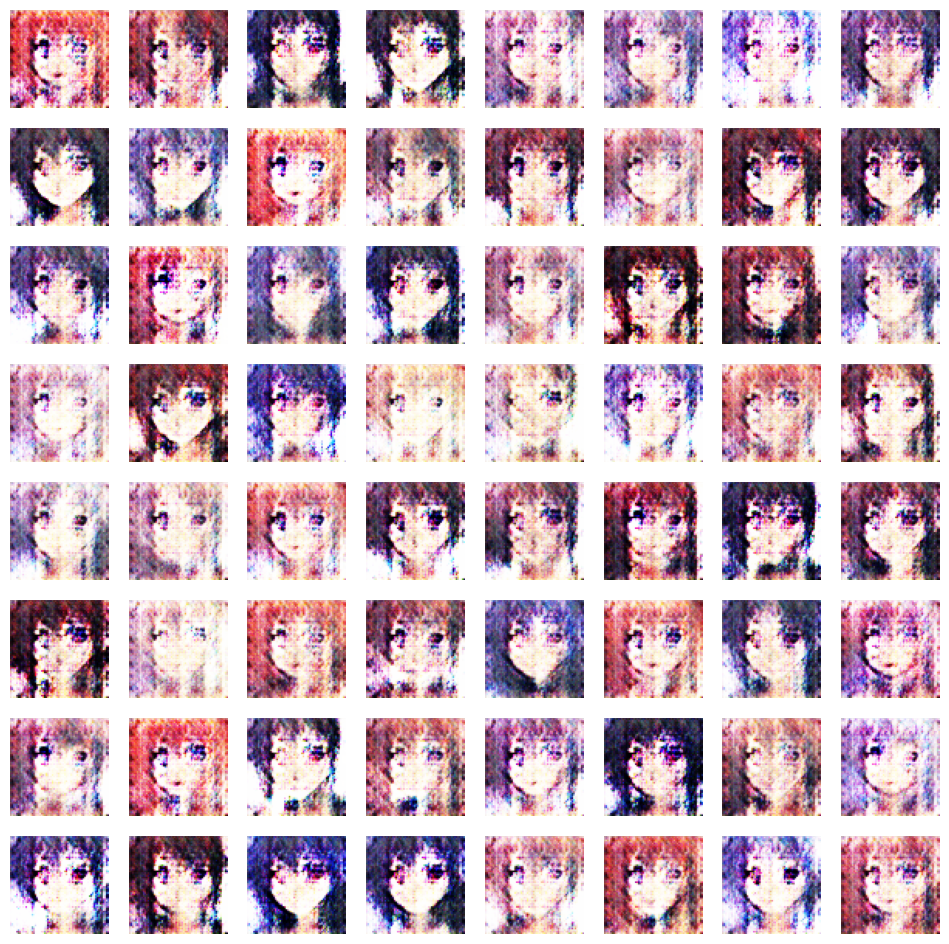

In [ ]:
generate_faces()